In [7]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

data = pd.read_csv("/content/creditcard.csv")
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [10]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0.0,260935,99.82
1,1.0,472,0.18


In [11]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values



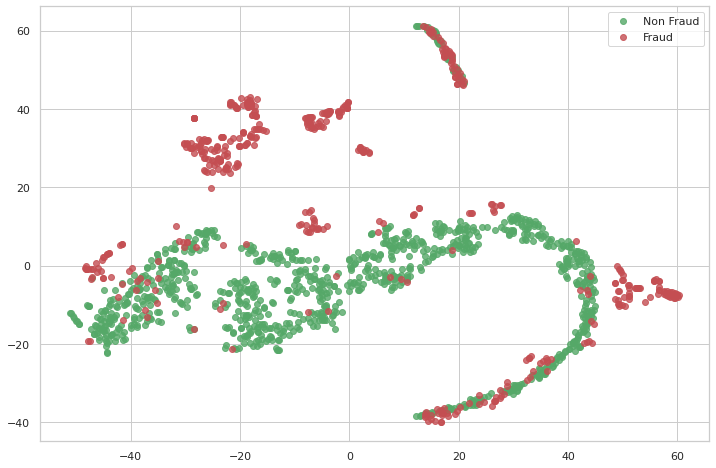

In [12]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

In [13]:
#Autoencoder implementation

#input layer
input_layer = Input(shape=(X.shape[1],))

#encoding part
encoded = Dense(100, activation = 'tanh', activity_regularizer= regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation = 'relu')(encoded)

#decoding part
decoded = Dense(50, activation = 'tanh')(encoded)
decoded = Dense(100, activation = 'tanh')(decoded)

# output layer
output_layer = Dense(X.shape[1], activation = 'relu')(decoded)




In [14]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer = "adadelta", loss = "mse")


In [15]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]


In [16]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000],
                batch_size = 256, epochs = 10,
                shuffle = True, validation_split = 0.20)

Epoch 1/10
7/7 [==============================] - 1s 38ms/step - loss: 0.2767 - val_loss: 0.2762
Epoch 2/10
7/7 [==============================] - 0s 9ms/step - loss: 0.2765 - val_loss: 0.2758
Epoch 3/10
7/7 [==============================] - 0s 9ms/step - loss: 0.2759 - val_loss: 0.2754
Epoch 4/10
7/7 [==============================] - 0s 9ms/step - loss: 0.2756 - val_loss: 0.2750
Epoch 5/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2753 - val_loss: 0.2746
Epoch 6/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2746 - val_loss: 0.2741
Epoch 7/10
7/7 [==============================] - 0s 9ms/step - loss: 0.2742 - val_loss: 0.2736
Epoch 8/10
7/7 [==============================] - 0s 9ms/step - loss: 0.2738 - val_loss: 0.2732
Epoch 9/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2731 - val_loss: 0.2726
Epoch 10/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2728 - val_loss: 0.2721


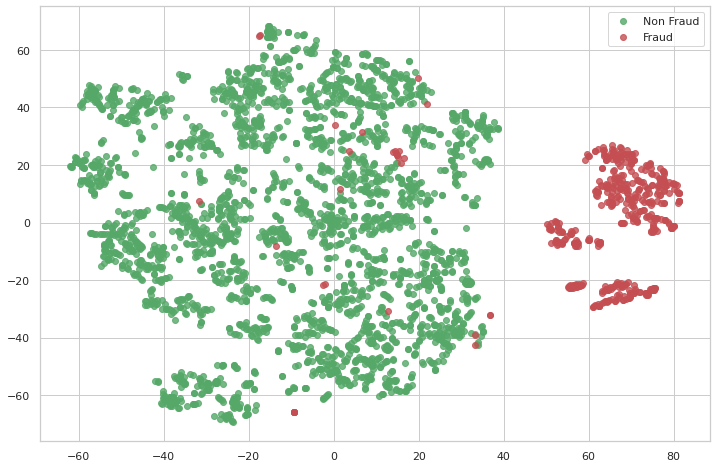

In [17]:
# point cluster seperation using autoencoders

hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])


norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)


rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")



In [18]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size = 0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print("")
print("Classification Report: ")
print(classification_report(val_y, pred_y))

print("")
print("Accuracy Score: ", accuracy_score(val_y, pred_y))



Classification Report: 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       754
         1.0       1.00      0.79      0.88       114

    accuracy                           0.97       868
   macro avg       0.98      0.89      0.93       868
weighted avg       0.97      0.97      0.97       868


Accuracy Score:  0.9723502304147466


In [19]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(train_x, train_y)
clf.score(val_x, val_y)

0.9585253456221198

In [26]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(12, input_dim=50, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=50, batch_size=10)
_, accuracy = model.evaluate(val_x, val_y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/50
261/261 [==============================] - 1s 1ms/step - loss: 0.4896 - accuracy: 0.8595
Epoch 2/50
261/261 [==============================] - 0s 1ms/step - loss: 0.3316 - accuracy: 0.8560
Epoch 3/50
261/261 [==============================] - 0s 1ms/step - loss: 0.1982 - accuracy: 0.9199
Epoch 4/50
261/261 [==============================] - 0s 1ms/step - loss: 0.1139 - accuracy: 0.9674
Epoch 5/50
261/261 [==============================] - 0s 1ms/step - loss: 0.0760 - accuracy: 0.9778
Epoch 6/50
261/261 [==============================] - 0s 1ms/step - loss: 0.0705 - accuracy: 0.9782
Epoch 7/50
261/261 [==============================] - 0s 1ms/step - loss: 0.0476 - accuracy: 0.9846
Epoch 8/50
261/261 [==============================] - 0s 1ms/step - loss: 0.0423 - accuracy: 0.9882
Epoch 9/50
261/261 [==============================] - 0s 1ms/step - loss: 0.0330 - accuracy: 0.9889
Epoch 10/50
261/261 [==============================] - 0s 1ms/step - loss: 0.0314 - accuracy: 0.9930

In [ ]:
# results


import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
try:
    data = pd.read_csv("/content/creditcard.csv")
except Exception as e:
    data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0, 0.5, 'Frequency')

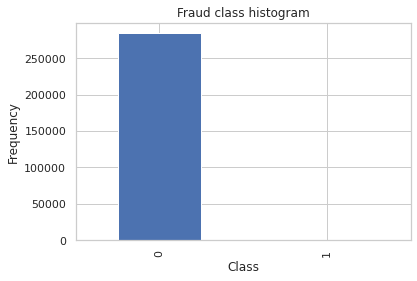

In [ ]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [ ]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# hour = data['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)
# data['hour'] = StandardScaler().fit_transform(hour.reshape(-1, 1))

data = data.drop(['Time','Amount'],axis=1)
data.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
class Autoencoder(object):

    def __init__(self, n_hidden_1, n_hidden_2, n_input, learning_rate):
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_input = n_input

        self.learning_rate = learning_rate

        self.weights, self.biases = self._initialize_weights()

        self.x = tf.compat.v1.placeholder("float", [None, self.n_input])
        

        self.encoder_op = self.encoder(self.x)
        self.decoder_op = self.decoder(self.encoder_op)

        self.cost = tf.reduce_mean(tf.pow(self.x - self.decoder_op, 2))
        self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.cost)

        init = tf.compat.v1.global_variables_initializer()
        self.sess = tf.compat.v1.Session()
        self.sess.run(init)

    def _initialize_weights(self):
        weights = {
            'encoder_h1': tf.Variable(tf.random.normal([self.n_input, self.n_hidden_1])),
            'encoder_h2': tf.Variable(tf.random.normal([self.n_hidden_1, self.n_hidden_2])),
            'decoder_h1': tf.Variable(tf.random.normal([self.n_hidden_2, self.n_hidden_1])),
            'decoder_h2': tf.Variable(tf.random.normal([self.n_hidden_1, self.n_input])),
        }
        biases = {
            'encoder_b1': tf.Variable(tf.random.normal([self.n_hidden_1])),
            'encoder_b2': tf.Variable(tf.random.normal([self.n_hidden_2])),
            'decoder_b1': tf.Variable(tf.random.normal([self.n_hidden_1])),
            'decoder_b2': tf.Variable(tf.random.normal([self.n_input])),
        }

        return weights, biases

    def encoder(self, X):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(X, self.weights['encoder_h1']),
                                       self.biases['encoder_b1']))
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['encoder_h2']),
                                       self.biases['encoder_b2']))
        return layer_2

    def decoder(self, X):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(X, self.weights['decoder_h1']),
                                       self.biases['decoder_b1']))
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['decoder_h2']),
                                       self.biases['decoder_b2']))
        return layer_2

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict={self.x: X})

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def transform(self, X):
        return self.sess.run(self.encoder_op, feed_dict={self.x: X})

    def reconstruct(self, X):
        return self.sess.run(self.decoder_op, feed_dict={self.x: X})

In [ ]:
good_data = data[data['Class'] == 0]
bad_data = data[data['Class'] == 1]
#print 'bad: {}, good: {}'.format(len(bad_data), len(good_data))

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

X_train = X_train[X_train['Class']==0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [ ]:
X_good = good_data.iloc[:, good_data.columns != 'Class']
y_good = good_data.iloc[:, good_data.columns == 'Class']

X_bad = bad_data.iloc[:, bad_data.columns != 'Class']
y_bad = bad_data.iloc[:, bad_data.columns == 'Class']

In [ ]:
model = Autoencoder(n_hidden_1=15, n_hidden_2=3, n_input=X_train.shape[1], learning_rate = 0.01)

In [ ]:
training_epochs = 100
batch_size = 256
display_step = 100
record_step = 10

In [ ]:
total_batch = int(X_train.shape[0]/batch_size)

cost_summary = []

for epoch in range(training_epochs):
    cost = None
    for i in range(total_batch):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        batch = X_train[batch_start:batch_end, :]
        
        cost = model.partial_fit(batch)
    
    if epoch % display_step == 0 or epoch % record_step == 0:
        total_cost = model.calc_total_cost(X_train)
        
        if epoch % record_step == 0:
            cost_summary.append({'epoch': epoch+1, 'cost': total_cost})
        
        if epoch % display_step == 0:
            print("Epoch:{}, cost={:.9f}".format(epoch+1, total_cost))

TypeError: ignored

In [ ]:

ax1.plot(list(map(lambda x: x['epoch'], cost_summary)), list(map(lambda x: x['cost'], cost_summary)))
ax1.set_title('Cost')

plt.xlabel('Epochs')
plt.show()

NameError: ignored

In [3]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import numpy as np
init_notebook_mode(connected=True)

## generate random data
N = 50
random_x = np.linspace(2, 10, N)
random_y1 = np.linspace(2, 10, N)
random_y2 = np.linspace(2, 10, N)

trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers", name="Actual Data")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines", name="Model")
layout = go.Layout(title="2D Data Repersentation Space", xaxis=dict(title="x2", range=(0,12)), 
                   yaxis=dict(title="x1", range=(0,12)), height=400, 
                   annotations=[dict(x=5, y=5, xref='x', yref='y', text='This 1D line is the Data Manifold (where data resides)',
                   showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                   ax=-120, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8)])
figure = go.Figure(data = [trace1], layout = layout)
iplot(figure)

In [4]:
random_y3 = [2 for i in range(100)]
random_y4 = random_y2 + 1
trace4 = go.Scatter(x = random_x[4:24], y = random_y4[4:300], mode="lines")
trace3 = go.Scatter(x = random_x, y = random_y3, mode="lines")
trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines")
layout = go.Layout(xaxis=dict(title="x1", range=(0,12)), yaxis=dict(title="x2", range=(0,12)), height=400,
                   annotations=[dict(x=2, y=2, xref='x', yref='y', text='A', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, 
                                     arrowcolor='#636363', ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8), 
                                dict(x=6, y=6, xref='x', yref='y', text='B', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                                     ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='yellow', opacity=0.8), dict(
                                     x=4, y=5, xref='x', yref='y',text='d', ay=-40), 
                                dict(x=2, y=2, xref='x', yref='y', text='angle L', ax=80, ay=-10)], title="2D Data Repersentation Space", showlegend=False)
data = [trace1, trace2, trace3, trace4]
figure = go.Figure(data = data, layout = layout)
iplot(figure)



#################

random_y3 = [2 for i in range(100)]
random_y4 = random_y2 + 1
trace4 = go.Scatter(x = random_x[4:24], y = random_y4[4:300], mode="lines")
trace3 = go.Scatter(x = random_x, y = random_y3, mode="lines")
trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines")
layout = go.Layout(xaxis=dict(title="u1", range=(1.5,12)), yaxis=dict(title="u2", range=(1.5,12)), height=400,
                   annotations=[dict(x=2, y=2, xref='x', yref='y', text='A', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, 
                                     arrowcolor='#636363', ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8), 
                                dict(x=6, y=6, xref='x', yref='y', text='B', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                                     ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='yellow', opacity=0.8), dict(
                                     x=4, y=5, xref='x', yref='y',text='d', ay=-40), 
                                dict(x=2, y=2, xref='x', yref='y', text='angle L', ax=80, ay=-10)], title="Latent Distance View Space", showlegend=False)
data = [trace1, trace2, trace3, trace4]
figure = go.Figure(data = data, layout = layout)
iplot(figure)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.



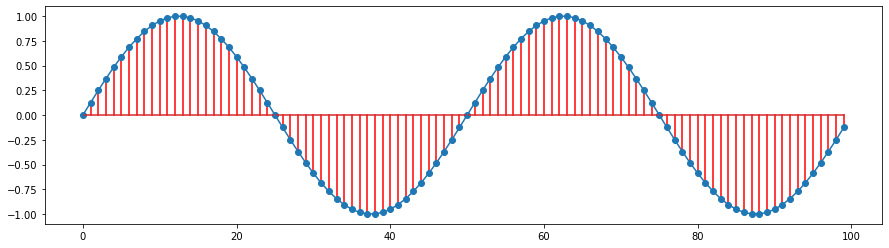

In [5]:
import matplotlib.pyplot as plt 
import numpy as np
fs = 100 # sample rate 
f = 2 # the frequency of the signal
x = np.arange(fs) # the points on the x axis for plotting
y = [ np.sin(2*np.pi*f * (i/fs)) for i in x]

% matplotlib inline
plt.figure(figsize=(15,4))
plt.stem(x,y, 'r', );
plt.plot(x,y);